In [8]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from astroExplain.spectra.explanation import TellMeWhy
from anomaly.constants import GALAXY_LINES
from anomaly.utils import line_width_from_velocity

In [2]:
# %%capture output
# set minor ticks on x axis as a default for all plots
# add minor ticks for all axes

def set_minorticks(axs):

    for ax in axs.flat:
        ax.minorticks_on()

In [3]:
# directories for data
bin_id = "bin_03"
user = "/home/edgar"
work_directory = f"{user}/spectra/0_01_z_0_5_4_0_snr_inf"
model = "256_128_64/latent_12/"
# metric = "mse_filter_250kms_noRel100"
metric = "mse_filter_250kms_noRel97"
# metric = "mse_noRel97"
# metric = "mse_filter_250kms_rel100"
# metric = "mse_filter_250kms_rel97"
# metric = "mse_rel100"
# metric = "mse_rel97"
data_directory = (
    f"{work_directory}/{bin_id}/"
    f"explanation/{model}/{metric}"
)

In [4]:
wave = np.load(f"{work_directory}/wave_spectra_imputed.npy")

anomalies = np.load(f"{data_directory}/top_anomalies.npy")

df_anomalies = pd.read_csv(
    f"{data_directory}/top_anomalies.csv.gz",
    index_col="specobjid"
)

median_spectrum = np.load(
    f"{work_directory}/{bin_id}/median_spectrum.npy"
)
mean_spectrum = np.load(
    f"{work_directory}/{bin_id}/average_spectrum.npy"
)

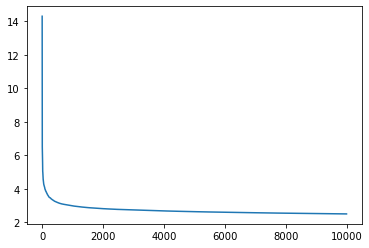

In [5]:
# sort scores in descending order in place in the df
df_anomalies.sort_values(by="score", ascending=False, inplace=True)
anomalies = anomalies[::-1]
plt.plot(df_anomalies["score"].to_numpy())

# Explore average patterns of all spectra and anomalies

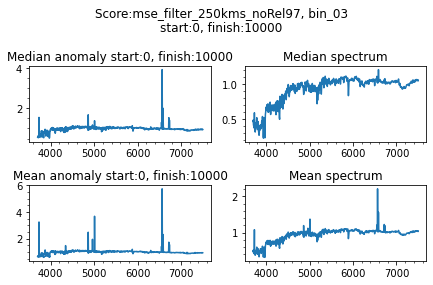

In [9]:
# average for anomalies from start_at to finish_at

# config
start_at = 0
finish_at = 10_000

assert start_at < finish_at and finish_at <= 10_000

#########################################################################
median_anomaly = np.median(
    anomalies[start_at:finish_at, :],
    axis=0
)
mean_anomaly = np.mean(
    anomalies[start_at:finish_at, :],
    axis=0
)

# compare against mean and median spectra
fig, axs = plt.subplots(
    2, 2,
    figsize=None,
    tight_layout=True
)

# add minor ticks for all axes
set_minorticks(axs)

# add title to the figure
fig.suptitle(
    f"Score:{metric}, {bin_id}\n"
    f"start:{start_at}, finish:{finish_at}",
    fontsize=12
)

axs[0, 0].plot(wave, median_anomaly)
axs[0, 0].set_title(
    f"Median anomaly start:{start_at}, finish:{finish_at}"
)

axs[1, 0].plot(wave, mean_anomaly)
axs[1, 0].set_title(f"Mean anomaly start:{start_at}, finish:{finish_at}")

axs[0, 1].plot(wave, median_spectrum)
axs[0, 1].set_title("Median spectrum")

axs[1, 1].plot(wave, mean_spectrum)
axs[1, 1].set_title("Mean spectrum")

# save median and mean spectra for later use
save_to = f"{data_directory}/mean_median_anomalous_spectra"

if os.path.exists(save_to) is False:

    os.mkdir(save_to)

np.save(
    f"{save_to}/median_anomaly_"
    f"start_{start_at}_finish_{finish_at}_"
    f"{metric}_{bin_id}.npy",
    median_anomaly
)

np.save(
    f"{save_to}/mean_anomaly_"
    f"start_{start_at}_finish_{finish_at}_"
    f"{metric}_{bin_id}.npy",
    mean_anomaly
)

# # save figure to pdf in Downloads folder
# fig.savefig(
#     f"{data_directory}/mean_median_spectra_anomaly_"
#     f"start_{start_at}_finish_{finish_at}_"
#     f"{metric}_{bin_id}.pdf"
# )

## Explore explanations

In [12]:
%%capture output
# config
median_smooth = True
drop_fraction = 0.05

# create array with weights for top all anomalies

explanations_directory = f"{data_directory}/000"

weights_all = np.empty(anomalies.shape)

for i, specobjid in enumerate(df_anomalies.index.to_numpy()):

    with open(
        f"{explanations_directory}/{specobjid}.pkl", "rb"
    ) as file:

        explanation = pickle.load(file)
        why = TellMeWhy(wave=wave, explanation=explanation)

        weights_all[i, :] = why.smooth_and_normalize_explanation(
            median_smooth=median_smooth,
            drop_fraction=drop_fraction 
        )

# new array to store the absolute values of the weights
weights_all_abs = np.abs(weights_all)

# save both arrays for later use

save_to = f"{data_directory}/explanation_weights"

if os.path.exists(save_to) is False:

    os.mkdir(save_to)

np.save(
    f"{save_to}/weights_all_"
    f"smooth_{median_smooth}_drop_{drop_fraction}_"
    f"{metric}_{bin_id}.npy",
    weights_all
)

np.save(
    f"{save_to}/weights_all_abs_"
    f"smooth_{median_smooth}_drop_{drop_fraction}_"
    f"{metric}_{bin_id}.npy",
    weights_all_abs
)

In [43]:
# how to match line_wavelengths from GALAXY_LINES to wave array

for line_name, line_wavelength in GALAXY_LINES.items():

    line_index = np.argmin(np.abs(wave - line_wavelength))

    print(
        f"{line_name}:\n wave:"
        f" {line_wavelength:.2f}, match:{wave[line_index]:.2f}"
    ) 

OII_3726:
 wave: 3726.04, match:3726.06
H_delta_4101:
 wave: 4101.73, match:4102.15
H_gamma_4340:
 wave: 4340.47, match:4340.21
H_beta_4861:
 wave: 4861.35, match:4861.34
OIII_4959:
 wave: 4958.91, match:4959.36
OIII_5006:
 wave: 5006.84, match:5006.38
NII_6548:
 wave: 6548.04, match:6547.76
H_alpha_6562:
 wave: 6562.79, match:6562.77
NII_6583:
 wave: 6583.46, match:6583.77
SII_6716:
 wave: 6716.44, match:6716.80
SII_6730:
 wave: 6730.81, match:6730.81


## Summary stats of explanation weights

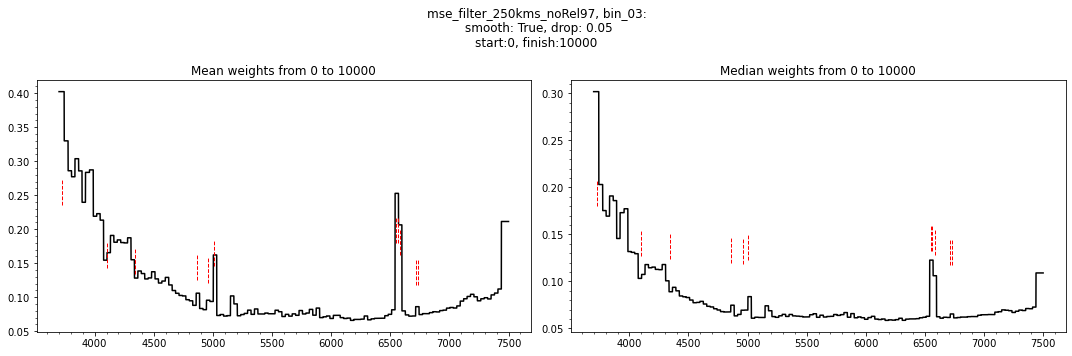

In [39]:
# mean and median of the explanation weights from start_at to finish_at
# config
start_at = 0
finish_at = 10_000

assert start_at < finish_at and finish_at <= 10_000

#########################################################################
mean_weights_abs_sf = np.mean(
    weights_all_abs[start_at:finish_at, :],
    axis=0
)

median_weights_abs_sf = np.median(
    weights_all_abs[start_at:finish_at, :],
    axis=0
)


# plot the mean and median of the weights
fig, axs = plt.subplots(
    1, 2,
    figsize=(15, 5),
    tight_layout=True
)

# add title to the figure
fig.suptitle(
    f"{metric}, {bin_id}:\n"
    f" smooth: {median_smooth}, drop: {drop_fraction}\n"
    f"start:{start_at}, finish:{finish_at}",
    fontsize=12
)

# add minor ticks for all axes
set_minorticks(axs)

axs[0].plot(wave, mean_weights_abs_sf, color="black")
axs[0].set_title(f"Mean weights from {start_at} to {finish_at}")

axs[1].plot(wave, median_weights_abs_sf, color="black")
axs[1].set_title(f"Median weights from {start_at} to {finish_at}")

# add labels of standard galaxy lines
for line_name, line_wavelength in GALAXY_LINES.items():

    line_index = np.argmin(np.abs(wave - line_wavelength))

    axs[0].axvline(
        x=line_wavelength,
        ymin=mean_weights_abs_sf[line_index]+0.1,
        ymax=mean_weights_abs_sf[line_index]+0.2,
        color="red",
        linestyle="--",
        linewidth=1,
    )
    axs[1].axvline(
        x=line_wavelength,
        ymin=median_weights_abs_sf[line_index]+0.2,
        ymax=median_weights_abs_sf[line_index]+0.3,
        color="red",
        linestyle="--",
        linewidth=1,
    )

        # ax.annotate(
        #     text=line_name,
        #     xy=(line_wavelength, mean_weights_abs_sf[line_index]),
        #     xytext=(0, 30),
        #     arrowprops=dict(arrowstyle="-", color="red"),
        #     textcoords="offset points",
        #     # rotation=90,
        #     # fontsize=8,
        #     color="red",
        #     horizontalalignment="center",
        #     verticalalignment="bottom",
        # )

# save figure to pdf in data directory
# fig.savefig(
#     f"{data_directory}/mean_median_weights_abs_"
#     f"from_{start_at}_to_{finish_at}_"
#     f"smooth_{median_smooth}_drop_{drop_fraction}_"
#     f"{metric}_{bin_id}.pdf"
# )

OII_3726:
 3726.04, 3726.056514128532
H_delta_4101:
 4101.734, 4102.1505376344085
H_gamma_4340:
 4340.472, 4340.210052513128
H_beta_4861:
 4861.352, 4861.340335083771
OIII_4959:
 4958.911, 4959.364841210303
OIII_5006:
 5006.843, 5006.376594148537
NII_6548:
 6548.041, 6547.761940485121
H_alpha_6562:
 6562.787, 6562.7656914228555
NII_6583:
 6583.461, 6583.770942735684
SII_6716:
 6716.44, 6716.804201050263
SII_6730:
 6730.812, 6730.8077019254815


## Analysis of raw values from explanation weights

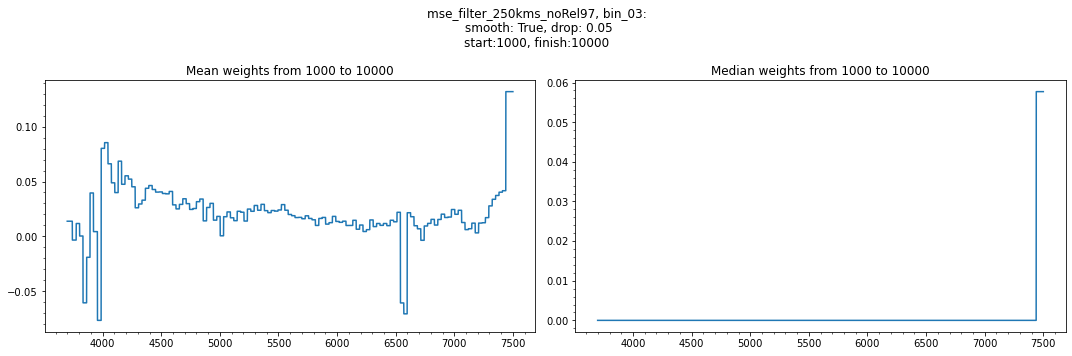

In [39]:
# mean and median of the explanation weights from start_at to finish_at
# config
start_at = 1000
finish_at = 10_000

assert start_at < finish_at and finish_at <= 10_000

#########################################################################

mean_weights_sf = np.mean(
    weights_all[start_at:finish_at, :],
    axis=0
)

median_weights_sf = np.median(
    weights_all[start_at:finish_at, :],
    axis=0
)


# plot the mean and median of the weights
fig, axs = plt.subplots(
    1, 2,
    figsize=(15, 5),
    tight_layout=True
)

# add title to the figure
fig.suptitle(
    f"{metric}, {bin_id}:\n"
    f" smooth: {median_smooth}, drop: {drop_fraction}\n"
    f"start:{start_at}, finish:{finish_at}",
    fontsize=12
)

# add minor ticks for all axes
set_minorticks(axs)

axs[0].plot(wave, mean_weights_sf)
axs[0].set_title(f"Mean weights from {start_at} to {finish_at}")

axs[1].plot(wave, median_weights_sf)
axs[1].set_title(f"Median weights from {start_at} to {finish_at}")

# save figure to pdf in data directory
# fig.savefig(
#     f"{data_directory}/mean_median_weights_"
#     f"from_{start_at}_to_{finish_at}_"
#     f"smooth_{median_smooth}_drop_{drop_fraction}_"
#     f"{metric}_{bin_id}.pdf"
# )